In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import zipfile
import time
import os
import cv2
import numpy as np
import json
import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, LSTM, Lambda, TimeDistributed
from keras.models import Model, load_model, model_from_json
from keras.backend import expand_dims
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger
from VideoDataGenerator import VideoDataGenerator
import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, LSTM, Lambda, TimeDistributed, Dropout, BatchNormalization
from keras.models import Model
from keras.backend import expand_dims
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def loadMetadata(file):
    jsonFile =  open(file)
    data = json.load(jsonFile)

    labels = {}
    testIDs = []
    validIDs = []
    # every fifth key is validID, the rest are testID
    
    for validID in data['valid'].keys():
        validIDs.append(validID)
        labels[validID] = {
          'label': data['valid'][validID]['label'],
          'audioPrediction': data['valid'][validID]['fakeAudioPrediction']
        }
        
    for testID in data['test'].keys():
        testIDs.append(testID)
        labels[testID] = {
          'label': data['test'][testID]['label'],
          'audioPrediction': data['test'][testID]['fakeAudioPrediction']
        }
        
    return (testIDs, validIDs, labels, len(testIDs), len(validIDs))

In [0]:
#    -- Image PreProcessing Model --

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
vid_input = Input(shape=(90, 150, 150, 3))

# First convolution extracts 4 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

model = TimeDistributed(Conv2D(4, (3,3), activation='relu'))(vid_input)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)

# Second convolution extracts 5 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

model = TimeDistributed(Conv2D(5, (3,3), activation='relu'))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)

# Third convolution extracts 10 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

model = TimeDistributed(Conv2D(10, (3,3), activation='relu'))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)


model = TimeDistributed(Flatten())(model)

model = TimeDistributed(Dense(512, activation='relu'))(model)
model = TimeDistributed(BatchNormalization())(model)
model = TimeDistributed(Dropout(0.2))(model)
model = TimeDistributed(Dense(256, activation='relu'))(model)
model = TimeDistributed(BatchNormalization())(model)
model = TimeDistributed(Dropout(0.2))(model)

model = LSTM(1)(model)
 
#    -- Audio PreProcessing Model --
aud_input = Input(shape=(1,))

# Put through a layer with linear activation
aud_model = Dense(1, activation='linear')(aud_input)

#     -- Concatenate Layers --
concatModel = concatenate([model, aud_model])

output = Dense(1, activation='sigmoid')(concatModel)

model = Model(inputs=[vid_input, aud_input], outputs=output)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90, 150, 150, 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 90, 148, 148, 112         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 90, 74, 74, 4 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 90, 74, 74, 4 16          time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [0]:
modelDirectory = '/home/jbschmid/models/v3'
dataDirectory = '/home/jbschmid/merged_data'

modelPath = os.path.join(modelDirectory, 'model.h5')
loadWeightsPath = os.path.join(modelDirectory, 'weights1.h5')
saveWeightsPath = os.path.join(modelDirectory, 'weights2.h5')
historyPath = os.path.join(modelDirectory, 'history.csv')
metadataPath =  './processed-metadata.json'

# load model
#model.save(modelPath)

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['acc'])

# Load previous training weights
model.load_weights(loadWeightsPath)
checkpoint = ModelCheckpoint(filepath=saveWeightsPath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

csvLogger = CSVLogger(historyPath, append=True, separator=';')

(testIDs, validIDs, labels, numTestIDs, numValidIDs) = loadMetadata(metadataPath)

epochs = 10
batchSize = 20
testStepsPerEpoch = int(numTestIDs / batchSize)
validStepsPerEpoch = int(numValidIDs / batchSize)

testGen = VideoDataGenerator(testIDs, labels, dataDirectory, 
                             batchSize=batchSize, videoDim=(150,150,3))
validGen = VideoDataGenerator(validIDs, labels, dataDirectory, 
                              batchSize=batchSize, videoDim=(150,150,3))


# Train model
history = model.fit_generator(
      generator=testGen,
      steps_per_epoch=testStepsPerEpoch,  
      epochs=epochs,
      validation_data=validGen,
      validation_steps=validStepsPerEpoch,
      workers=8,
      callbacks=[checkpoint, csvLogger]
      )


Epoch 1/10
389/389 [==============================] - 608s 2s/step - loss: 0.2915 - acc: 0.8794 - val_loss: 0.4709 - val_acc: 0.7747

Epoch 00001: val_acc improved from -inf to 0.77474, saving model to /home/jbschmid/models/v3/weights2.h5
Epoch 2/10
389/389 [==============================] - 600s 2s/step - loss: 0.2853 - acc: 0.8838 - val_loss: 0.5471 - val_acc: 0.7655

Epoch 00002: val_acc did not improve from 0.77474
Epoch 3/10
389/389 [==============================] - 603s 2s/step - loss: 0.2734 - acc: 0.8896 - val_loss: 0.5078 - val_acc: 0.7964

Epoch 00003: val_acc improved from 0.77474 to 0.79639, saving model to /home/jbschmid/models/v3/weights2.h5
Epoch 4/10
389/389 [==============================] - 602s 2s/step - loss: 0.2727 - acc: 0.8900 - val_loss: 0.5944 - val_acc: 0.7603

Epoch 00004: val_acc did not improve from 0.79639
Epoch 5/10
389/389 [==============================] - 602s 2s/step - loss: 0.2685 - acc: 0.8928 - val_loss: 0.5102 - val_acc: 0.7985

Epoch 00005: val_

Text(0.5, 1.0, 'Training and validation loss')

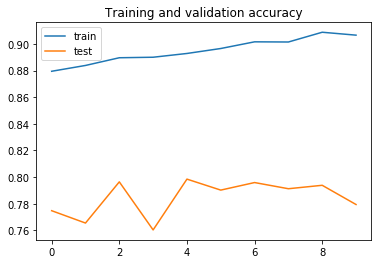

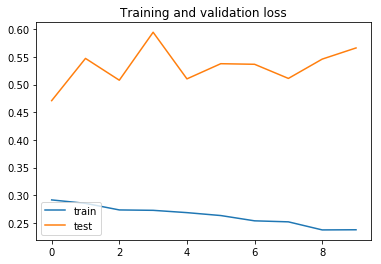

In [0]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train', 'test'], loc='lower left')
plt.title('Training and validation loss')